# Image Captioning with Transformers
Sub PJT 2에서는 Sub PJT 3에서 사용할 GPT2를 사용하기에 앞서, transformer 모델에 더 익숙해지고, 이를 활용하여 이미지 캡셔닝(image captioning) 모델을 구현합니다.
본 실습에서는 transformer decoder의 핵심 구성 요소를 구현해야 하기 때문에 Sub PJT 1과 2 명세서에 설명한 transformer에 대한 정확한 이해가 선행되어야 합니다.
작은 데이터로 모델을 학습시킬 것이 때문에, overfitting 현상이 일어나는 점 참고 바랍니다.

## 준비
먼저 필요한 모듈들을 import하고, 에러를 측정하는 함수를 정의합니다.

In [1]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from lib.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from lib.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


import numpy as np
import matplotlib.pyplot as plt

from lib.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from lib.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# 상대적인 에러 측정 함수
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# COCO Dataset
본 실습에서는 COCO dataset을 사용하여 transformer를 학습시킵니다.
앞서 언급한대로, 데이터셋은 기존 COCO Dataset의 일부로, 그 크기가 매우 작습니다.

## 데이터셋 다운로드
./lib/datasets/ 디렉토리로 이동하여 데이터를 다운로드합니다.

In [ ]:
%cd ./lib/datasets/
!wget "http://cs231n.stanford.edu/coco_captioning.zip"
!unzip coco_captioning.zip
!rm coco_captioning.zip
!wget http://cs231n.stanford.edu/imagenet_val_25.npz
%cd ../../

## 데이터 형태 출력하기
아래 코드를 실행하여 다운로드한 데이터 형태를 출력해 봅니다.
본 실험에서는 이미지의 특징 벡터(feature vector)는 데이터로 이미 주어지고, 주어진 특징 벡터를 바탕으로 텍스트를 생성하는 transformer를 학습시킵니다.

In [3]:

# COCO data를 디스크로 부터 dictionary 형태로 load
data = load_coco_data(pca_features=True)

# data dictionary의 key와 value를 출력
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/lib/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# Transformer
이미지 캡셔닝 모델 구현에 앞서, transformer ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) 에 대해서 복습해 봅니다.
Transformer는 컴퓨터 비전과 자연어 처리 등의 다양한 딥러닝 모델들에 적용되고, 특히 Sub PJT3에서 사용할 언어 모델인 GPT2에도 사용됩니다.
본 실습에서는 이미지 캡셔닝 모델 관점에서 transformer 사용되지만, 실습을 통해 transformer의 가장 핵심 요소인 "attention"이라는 개념을 꼭 숙지 해야 합니다.

# Transformer: Multi-Headed Attention

### Dot-Product Attention

Attention 연산은 query $q\in\mathbb{R}^d$, value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, 그리고 key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$ 가 주어졌을 때 아래와 같이 연산됩니다:

\begin{align}
c = \sum_{i=1}^{n} v_i \alpha_i &\alpha_i = \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

이때 $\alpha_i$는 "attention weights" 이라고 불리고, 이는 key와 query 값의 내적과 softmax 연산을 통해서 구할 수 있습니다.
최종 출력 $c\in\mathbb{R}^d$ 는 value vector들의 weighted average로 표현됩니다.

### Self-Attention
Transformer에서는 입력 $X \in \mathbb{R}^{\ell \times d}$ ($\ell$ 은 시퀀스 길이)로 부터 key, value, query를 얻어서 self-attention을 구현합니다. 구체적으로, 아래와 같이 입력 $X$ key, value, query로 매핑시켜주는 $V,K,Q \in \mathbb{R}^{d\times d}$ 파라미터를 학습합니다:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
Multi-headed attention의 경우, 각 head 별로 $V,K,Q \in \mathbb{R}^{d\times d}$ 파라미터를 학습합니다. 하나가 아니라 "multi" head 통해, 모델은 입력의 더욱 다양한 영역에 attend를 하여 풍부한 표현력을 가질 수 있습니다.
$h$ 를 head의 개수라고 하고, $Y_i$ 를 head $i$ attention output이라고 할 때, 각 head $i$ 별로 $Q_i$, $K_i$, $V_i$를 학습한다고 이해할 수 있습니다.
Single-headed attention을 할때와 동일한 computation complexity를 갖기 위해서 각 파라미터의 디멘젼 $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$, $V_i \in \mathbb{R}^{d\times d/h}$로 설정해 줍니다. Scaling term $\frac{1}{\sqrt{d/h}}$ 를 위에서 정의한 attention에 넣어주면, 아래와 같이 수식을 작성할 수 있습니다:

\begin{equation} \label{qkv_eqn}
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)
\end{equation}

이때 $Y_i\in\mathbb{R}^{\ell \times d/h}$ 이고, $\ell$ 은 시퀀스 길이 입니다.

본 실습에서는 아래와 같이 attention map에 dropout을 적용합니다:

\begin{equation} \label{qkvdropout_eqn}
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)
\end{equation}

최종적으로 각 head의 self-attention 결과를 concatenate한 뒤 linear transformation을 거쳐서 최종 결과물로 출력됩니다:

\begin{equation}
Y = [Y_1;\dots;Y_h]A
\end{equation}

, $A \in\mathbb{R}^{d\times d}$, $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

### Req 2-1: multi-head scaled dot-product attention 구현
`lib/transformer_layers.py` 에 있는 `MultiHeadAttention` 클래스 내의 multi-head scaled dot-product attention을 구현합니다.
아래는 구현 결과를 검증하기 위한 코드입니다. **본 코드에서 측정하는 상대적 에러는 `e-2`보다 작아야 합니다.**

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math

In [18]:
############################################################################
# Req 2-1: multi-head scaled dot-product attention 구현                     #
############################################################################
class MultiHeadAttention(nn.Module):
    """
    "Attention Is All You Need" (https://arxiv.org/abs/1706.03762)에서 소개된
    masked attention의 간단한 버전의 모델 layer입니다.
    Usage:
      attn = MultiHeadAttention(embed_dim, num_heads=2)
      # self-attention
      data = torch.randn(batch_size, sequence_length, embed_dim)
      self_attn_output = attn(query=data, key=data, value=data)
      # attention using two inputs
      other_data = torch.randn(batch_size, sequence_length, embed_dim)
      attn_output = attn(query=data, key=other_data, value=other_data)
    """

    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        MultiHeadAttention layer를 정의합니.
        Inputs:
         - embed_dim: Dimension of the token embedding
         - num_heads: Number of attention heads
         - dropout: Dropout probability
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        # 본 실습에서 사용한 key, query, value, proj 레이어의 정의입니다.
        # 실습 내의 random seed가 고정되어 있기 때문에, 아래 정의된 레이어의 순서를 바꾸면 안됩니다.
        self.key = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)

        ############################################################################
        # TODO: 앞서 정의된 layer 이외에 Transformer_Captioning.ipynb를 참고하여 attention #
        # 연산 수행을 위한 레이어들을 정의합니다.                                            #
        # 또한 softmax step 이후에 dropout을 사용하기 때문에 해당 레이어 정의도 필요합니다.        #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.dropout = nn.Dropout(p = dropout)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def forward(self, query, key, value, attn_mask=None):
        """
        제공된 data의 masked attention output을 연산합니다.
        이때 모든 attention head들은 병렬적으로 연산합니다.
        파라미터 shape에 대한 정의는 다음과 같습니다.
        N: batch size / S: source sequence length / T: target sequence length / E: embedding dimension.

        Inputs:
        - query: Input data to be used as the query, of shape (N, S, E)
        - key: Input data to be used as the key, of shape (N, T, E)
        - value: Input data to be used as the value, of shape (N, T, E)
        - attn_mask: Array of shape (T, S) where mask[i,j] == 0 indicates token
          i in the target should not be influenced by token j in the source.
        Returns:
        - output: Tensor of shape (N, S, E) giving the weighted combination of
          data in value according to the attention weights calculated using key
          and query.
        """
        N, S, D = query.shape
        N, T, D = value.shape
        # Create a placeholder, to be overwritten by your code below.
        #output = torch.empty((N, T, D))

        ############################################################################
        # TODO: Transformer_Captioning.ipynb의 multiheaded attention 수식을 구현합니다. #
        # 힌트:                                                                     #
        #  1) Shape을 (N, T, E) 에서 (N, T, H, E/H)로 변환해야 합니다.                    #
        #     이때 H 는 head의 개수입니다.                                               #
        #  2) torch.matmul 병렬적으로 batch matrix multiply을 수행할 수 있습니다.           #
        #     https://pytorch.org/docs/stable/generated/torch.matmul.html          #
        #  3) value 값에 영향을 주지 않기 위해서 score가 어떤식으로 출력되어야 하는지 생각하여        #
        #     attn_mask를 적용해 봅니다.                                                #
        #     PyTorch의 masked_fill 함수를 참고합니다.                                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        q = self.query(query)
        k = self.key(key)
        v = self.value(value)

        #split
        q = q.view(N, -1, self.num_heads, self.embed_dim//self.num_heads)
        k = k.view(N, -1, self.num_heads, self.embed_dim//self.num_heads)
        v = v.view(N, -1, self.num_heads, self.embed_dim//self.num_heads)

        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        #scores
        scores = torch.matmul(q, k.transpose(-2,-1))/math.sqrt(self.embed_dim/self.num_heads)

        #masking
        if attn_mask is not None:

            mask = attn_mask.unsqueeze(0).unsqueeze(1)
            scores = scores.masked_fill_(mask == False, -(10**12))

        #softmax
        scores = F.softmax(scores, dim = -1)
        scores = self.dropout(scores)
        scores = torch.matmul(scores, v)

        #concatenation
        output = scores.transpose(1,2).contiguous().view(N, -1, self.embed_dim)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return self.proj(output)

In [19]:
torch.manual_seed(123)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[[ 0.2045, -0.2835,  0.3818,  0.0162,  0.067,   0.0391,  0.2474, -0.1704],
  [ 0.3565, -0.4814,  0.1685, -0.1636, -0.1559,  0.164,   0.0828, -0.1876],
  [ 0.3478, -0.4419,  0.2334, -0.2082, -0.0563,  0.1624,  0.1341, -0.2085]]])

expected_masked_self_attn_output = np.asarray([[[ 0.6067, -1.4054, -0.3671, -0.8228, -0.2016,  0.9012,  0.1293, -0.8373],
  [ 0.3812, -0.8076,  0.1075, -0.4247, -0.0804,  0.4659,  0.1347, -0.3882],
  [ 0.3994, -0.4801,  0.1653, -0.2918, -0.1215,  0.1917,  0.0911, -0.2506]]])

expected_attn_output = np.asarray([[[-0.2223, -0.08,    0.8046,  0.5508,  0.0229, -0.0801,  0.375,  -0.0188],
  [-0.2504, -0.0431,  0.8708,  0.5467,  0.0791, -0.2084,  0.4019,  0.0505],
  [-0.0887, -0.0811,  0.7949,  0.2688,  0.0768, -0.5126,  0.3118,  0.2228]]])


print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0015238490619760975
masked_self_attn_output error:  0.00030222561441895407
attn_output error:  0.00047722498994817475


# Positional Encoding
Transformer는 attention 매커니즘에 의해 입력 내에서 다양한 부분을 attend할 수 있지만, 입력 token의 순서를 알 수 있는 방법은 없습니다.
하지만 자연어 처리와 같은 태스크에서는 token의 순서가 매우 중요합니다.
이를 해결하고자 transformer의 저자들은 각 단어 token의 순서를 지정해 줄 수 있는 positional encoding을 더해줬습니다.

Positional encoding은 $P \in \mathbb{R}^{l\times d}$ matrix로 정의 하고 matrix의 값은 아래와 같이 정의됩니다.

$
P_{ij} =
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$

따라서 transformer에 입력값 $X \in \mathbb{R}^{l\times d}$ 를 바로 입력하는 대신, positional encoding이 더해진 $X + P$를 모델에 입력합니다.

### Req 2-2: PositionalEncoding 구현
`lib/transformer_layers.py` 에 있는 `PositionalEncoding` 을 구현합니다.
아래는 구현 결과를 검증하기 위한 코드입니다. **본 코드에서 측정하는 상대적 에러는 `e-3`보다 작아야 합니다.**

In [25]:
############################################################################
# Req 2-2: PositionalEncoding 구현                                          #
############################################################################
class PositionalEncoding(nn.Module):
    """
    각 토큰들의 위치 정보를 인코딩해주는 역할을 합니다. Positional encoding 레이어에는 간단한
    sine, cosine 함수로 구현되어 있기 때문에 별도의 학습 가능한 파라미터는 없습니다.
    """

    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        """
        PositionalEncoding 레이어 구현.
        Inputs:
         - embed_dim: the size of the embed dimension
         - dropout: the dropout value
         - max_len: the maximum possible length of the incoming sequence
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        assert embed_dim % 2 == 0
        # Create an array with a "batch dimension" of 1 (which will broadcast
        # across all examples in the batch).
        pe = torch.zeros(1, max_len, embed_dim, dtype = torch.float64)
        ############################################################################
        # TODO: Transformer_Captioning.ipynb에 서술된 positional encoding array 구현   #
        # 본 실습의 목표는 pe 매트릭스의 row를 exponent 0, 0, 2, 2, 4, 4, etc. 로 구성된      #
        # sine, cosine 함수를 번갈아 사용하여 embed_dim의 크기 까지로 구현하는 것입니다.          #
        # 전체 구현 코드는 5줄 정도 됩니다                                                 #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        for i in range(max_len):

            for j in range(embed_dim):

                if j % 2 == 0:

                    pe[0][i][j] = math.sin(i * (1e4**(-j/embed_dim)))

                else:

                    pe[0][i][j] = math.cos(i * (1e4**(-(j-1)/embed_dim)))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Positional encoding은 모델 파라미터와 함께 저장됩니다.
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Element-wise로 입력 시퀀스에 positional embeddings을 더해줍니다.
        Inputs:
         - x: the sequence fed to the positional encoder model, of shape
              (N, S, D), where N is the batch size, S is the sequence length and
              D is embed dim
        Returns:
         - output: the input sequence + positional encodings, of shape (N, S, D)
        """
        N, S, D = x.shape
        # Create a placeholder, to be overwritten by your code below.
        output = torch.empty((N, S, D), dtype = torch.float64)
        ############################################################################
        # TODO: 입력 시퀀스의 동일한 index에 positional encoding을 더해줍니다.               #
        # positional encoding을 더한 뒤 dropout도 적용해주어야 합니다                       #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        for n in range(N):

            for i in range(S):

                for j in range(D):

                    output[n][i][j] = x[n][i][j] + self.pe[0][i][j]

        output = self.dropout(output)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        return output

In [26]:
torch.manual_seed(123)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-0.1239,  1.2448, -0.4107,  0.,     -1.3299,  1.3436],
  [-0.,     -0.2386, 0.4114,  0.9893,  0.2361,  0.    ]]])

print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.0001923265481869226


# Transformer for Image Captioning
앞서 구현한 것들을 모두 조합하여, 드디어 transformer 기반의 이미지 캡셔닝 모델을 구현합니다. `lib/classifiers/transformer.py`을 열고, `CaptioningTransformer` 클래스를 살펴봅니다.

### Req 2-3: `CaptioningTransformer` 클래스의 `forward` 함수 구현
함수를 구현 한 뒤 아래 코드를 실행하여 작은 test 데이터에 대해서 평가를 해봅니다.
**본 코드에서 측정하는 에러는 `e-5`보다 작아야 합니다.**

In [9]:
import numpy as np
import copy

import torch
import torch.nn as nn

In [27]:
class TransformerDecoderLayer(nn.Module):
    """
    TransformerDecoder에서 사용될 Transformer decoder의 single layer.
    """
    def __init__(self, input_dim, num_heads, dim_feedforward=2048, dropout=0.1):
        """
        TransformerDecoderLayer instance 생성합니.
        Inputs:
         - input_dim: Number of expected features in the input.
         - num_heads: Number of attention heads
         - dim_feedforward: Dimension of the feedforward network model.
         - dropout: The dropout value.
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(input_dim, num_heads, dropout)
        self.multihead_attn = MultiHeadAttention(input_dim, num_heads, dropout)
        self.linear1 = nn.Linear(input_dim, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, input_dim)

        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()


    def forward(self, tgt, memory, tgt_mask=None):
        """
        입력값(mask와 함께)을 decoder layer에 넣어줍니다.

        Inputs:
        - tgt: the sequence to the decoder layer, of shape (N, T, W)
        - memory: the sequence from the last layer of the encoder, of shape (N, S, D)
        - tgt_mask: the parts of the target sequence to mask, of shape (T, T)
        Returns:
        - out: the Transformer features, of shape (N, T, W)
        """
        # Perform self-attention on the target sequence (along with dropout and
        # layer norm).
        tgt2 = self.self_attn(query=tgt, key=tgt, value=tgt, attn_mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Attend to both the target sequence and the sequence from the last
        # encoder layer.
        tgt2 = self.multihead_attn(query=tgt, key=memory, value=memory)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Pass
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super().__init__()
        self.layers = clones(decoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, tgt, memory, tgt_mask=None):
        output = tgt

        for mod in self.layers:
            output = mod(output, memory, tgt_mask=tgt_mask)

        return output

In [28]:
############################################################################
# Req 2-3: `CaptioningTransformer` 클래스의 `forward` 함수 구현                 #
############################################################################
class CaptioningTransformer(nn.Module):
    """
    CaptioningTransformer 는 image feature로 부터 captoin을 생성하는 Transformer decoder 입니다.
    해당 Transformer는 size D의 벡터를 입력으로 받고, size V의 vocab size, length T의 시퀀스를 다루고,
    dimension W의 word vector를 사용하며, size N의 minibatch에서 동작합니다.
    """
    def __init__(self, word_to_idx, input_dim, wordvec_dim, num_heads=4,
                 num_layers=2, max_length=50):
        """
        CaptioningTransformer instance를 생성합니다.
        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries.
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - num_heads: Number of attention heads.
        - num_layers: Number of transformer layers.
        - max_length: Max possible sequence length.
        """
        super().__init__()

        self.vocab_size = len(word_to_idx)
        self._null = word_to_idx["<NULL>"]
        self._start = word_to_idx.get("<START>", None)
        self._end = word_to_idx.get("<END>", None)

        self.visual_projection = nn.Linear(input_dim, wordvec_dim)
        self.embedding = nn.Embedding(self.vocab_size, wordvec_dim, padding_idx=self._null)
        self.positional_encoding = PositionalEncoding(wordvec_dim, max_len=max_length)

        decoder_layer = TransformerDecoderLayer(input_dim=wordvec_dim, num_heads=num_heads)
        self.transformer = TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.apply(self._init_weights)

        self.output = nn.Linear(wordvec_dim, self.vocab_size)

    def _init_weights(self, module):
        """
        네트워크 파라미터 초기화
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, features, captions):
        """
        Image features와 caption 토큰들이 주어졌을 때, 각 timestep 별로 가능한 토큰의 분포를 return합니다.
        전체 caption 시퀀스가 한번에 제공되기 때문에, 아직 예측하지 않은 미래 timestep은 마스킹을 해야합니다.
        Inputs:
         - features: image features, of shape (N, D)
         - captions: ground truth captions, of shape (N, T)
        Returns:
         - scores: score for each token at each timestep, of shape (N, T, V)
        """
        N, T = captions.shape
        # Create a placeholder, to be overwritten by your code below.
        scores = torch.empty((N, T, self.vocab_size))
        ############################################################################
        # TODO: CaptionTransformer의 forward 함수 구현.                                #
        # 구현 내용:                                                                 #
        #  1) 먼저 캡션을 임베딩화 한 뒤, positional_encoding을 적용합니다.                 #
        #     또한 image feature을 동일 embedding space에 projection 합니다.            #
        #  2) 아직 생성되지 않은 미래 timestep의 캡션을 마스킹할 tgt_mask를 준비합니다.         #
        #     이 때 torch.tril() 함수를 사용할 수 있습니다.                               #
        #  3) 최종적으로 transformer에 캡션 임베딩, projection된 image feature, 그리고     #
        #     tgt_mask를 전달합니다. Transformer에서 나온 결과로 score 값을 계산합니다.       #
        #     Score 값은 Transformer의 결과를 self.output() 레이어를 거쳐 얻을 수 있습니다.  #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        captions = self.embedding(captions)

        captions = self.positional_encoding(captions)

        features = self.visual_projection(features).unsqueeze(1)

        tgt_mask = torch.ones(T,T, dtype = captions.dtype)
        tgt_mask = torch.tril(tgt_mask)

        scores = self.transformer(captions,features,tgt_mask = tgt_mask)

        scores = self.output(scores)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return scores

    def sample(self, features, max_length=30):
        """
        Image features가 주어졌을 때, greedy decoding을 통해 이미지 캡션을 예측합니다.
        Inputs:
         - features: image features, of shape (N, D)
         - max_length: maximum possible caption length
        Returns:
         - captions: captions for each example, of shape (N, max_length)
        """
        with torch.no_grad():
            features = torch.Tensor(features)
            N = features.shape[0]

            # Create an empty captions tensor (where all tokens are NULL).
            captions = self._null * np.ones((N, max_length), dtype=np.int32)

            # Create a partial caption, with only the start token.
            partial_caption = self._start * np.ones(N, dtype=np.int32)
            partial_caption = torch.LongTensor(partial_caption)
            # [N] -> [N, 1]
            partial_caption = partial_caption.unsqueeze(1)

            for t in range(max_length):

                # Predict the next token (ignoring all other time steps).
                output_logits = self.forward(features, partial_caption)
                output_logits = output_logits[:, -1, :]

                # Choose the most likely word ID from the vocabulary.
                # [N, V] -> [N]
                word = torch.argmax(output_logits, axis=1)

                # Update our overall caption and our current partial caption.
                captions[:, t] = word.numpy()
                word = word.unsqueeze(1)
                partial_caption = torch.cat([partial_caption, word], dim=1)

            return captions

In [29]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

# transformer 인스턴스 생성
transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

# Set all model parameters to fixed values
for p in transformer.parameters():
    p.data = torch.tensor(np.linspace(-1.4, 1.3, num=p.numel()).reshape(*p.shape))

features = torch.tensor(np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D))
captions = torch.tensor((np.arange(N * T) % V).reshape(N, T))

scores = transformer(features, captions)
expected_scores = np.asarray([[[-16.9532,   4.8261,  26.6054],
         [-17.1033,   4.6906,  26.4844],
         [-15.0708,   4.1108,  23.2924]],
        [[-17.1767,   4.5897,  26.3562],
         [-15.6017,   4.8693,  25.3403],
         [-15.1028,   4.6905,  24.4839]],
        [[-17.2172,   4.7701,  26.7574],
         [-16.6755,   4.8500,  26.3754],
         [-17.2172,   4.7701,  26.7574]],
        [[-16.3669,   4.1602,  24.6872],
         [-16.7897,   4.3467,  25.4831],
         [-17.0103,   4.7775,  26.5652]]])
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  5.056720614439509e-06


# Overfit Transformer Captioning Model on Small Data

### Req 2-4: `CaptioningSolverTransformer` 클래스의 `transformer_temporal_softmax_loss` 함수 구현
`lib/captioning_solver_transformer.py`을 열고, `CaptioningSolverTransformer` 클래스 내에서 loss를 계산하는 코드를 구현합니다.

### Req 2-5: `CaptioningSolverTransformer` 클래스의 `_step` 함수 구현
`lib/captioning_solver_transformer.py`을 열고, `CaptioningSolverTransformer` 클래스 내에서 single gradient update를 하는 코드를 구현합니다.


구현을 완료한 뒤 아래 코드를 실행하여 작은 데이터셋에 대해서 transformer 기반의 이미지 캡셔닝 모델을 오버피팅 시켜봅니다.
학습 데이터에 대해서 loss 그래프는 감소하는 형태를 띄어야 합니다.

In [13]:
import numpy as np

from lib import optim
from lib.coco_utils import sample_coco_minibatch, decode_captions

import torch


class CaptioningSolverTransformer(object):
    """
    CaptioningSolverTransformer 클래스에는 transformer 기반의 이미지 캡셔닝 모델을
    학습시키기 위해서 필요한 로직들을 모두 포함하고 있습니다.
    모델을 학습시키기 위해서는 먼저 모델, 데이터셋, 다양한 옵션(learning rate, batch size, etc)를
    전달하여 CaptionSolverTransformer instance를 생성해야 합니다.
    Instance를 생성한 이후 train() 메소드를 호출하여 학습을 진행할 수 있습니다.
    학습이 완료된 이후 solver 내의 loss_history에는 학습 시 기록했던 loss 값들이 저장되어 있습ㄴ디ㅏ.

    위의 process에 대한 예시 코드는 다음과 같습니다:
    data = load_coco_data()
    model = MyAwesomeTransformerModel(hidden_dim=100)
    solver = CaptioningSolver(model, data,
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    API:
      Inputs:
      - features: Array giving a minibatch of features for images, of shape (N, D
      - captions: Array of captions for those images, of shape (N, T) where
        each element is in the range (0, V].
      Returns:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, idx_to_word, **kwargs):
        """
        CaptioningSolver instance를 생성합니다.
        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data from load_coco_data
        Optional arguments:
        - learning_rate: Learning rate of optimizer.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.learning_rate = kwargs.pop("learning_rate", 0.001)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)

        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)
        self.optim = torch.optim.Adam(self.model.parameters(), self.learning_rate)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        self._reset()

        self.idx_to_word = idx_to_word

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.loss_history = []

    ############################################################################
    # Req 2-5: single gradient update를 위한 _step() 함수 구현                     #
    ############################################################################
    def _step(self):
        """
        모델 학습 시 single gradient update를 수행합니다. train() 메소드 내에서 호출되며, 인위적으로 호출해서는 안됩니다.
        """
        # Make a minibatch of training data
        minibatch = sample_coco_minibatch(
            self.data, batch_size=self.batch_size, split="train"
        )
        captions, features, urls = minibatch
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        mask = captions_out != self.model._null

        ############################################################################
        # TODO: single gradient update를 위한 _step() 함수 구현                        #
        # 학습을 위한 데이터 준비는 완료되었고, 해당 데이터로 single gradient update를 수행합니다.  #
        # 1) Minibatch 내의 데이터를 torch 텐서로 변환해 줍니다.                            #
        # 2) model에 image feature와 t_captions_in을 전달하여 예측한 값을 return 받습니다.   #
        # 3) Req 2-4에서 작성한 transformer_temporal_softmax_loss()를 호출하여 loss 값을  #
        #   측정합니다.                                                               #
        # 4) loss_history에 저장하고, backward() 스텝을 거친 후 optimizer를 업데이트 합니다.   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        captions_in = torch.LongTensor(captions_in)
        captions_out = torch.LongTensor(captions_out)
        features = torch.Tensor(features)
        mask = torch.LongTensor(mask)

        scores = self.model(features, captions_in)

        loss = self.transformer_temporal_softmax_loss(scores, captions_out, mask)

        self.loss_history.append(loss.detach().numpy())

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def train(self):
        """
        학습 시작을 위한 코드입니다.
        """
        num_train = self.data["train_captions"].shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter.
            epoch_end = (t + 1) % iterations_per_epoch == 0

    ############################################################################
    # Req 2-4: 학습 loss 계산 코드 구현                                             #
    ############################################################################
    def transformer_temporal_softmax_loss(self, x, y, mask):
        """
        Timeseries 길이 T가 주어졌을 때, 각 timestep 별로 주어지는 size N minibatch 에서
        vocabulary size V에 대한 prediction을 수행합니다.
        입력 x는 모든 timestep의 token들에 해당하는 vocabulary를 예측하고, y는 각 timestep별로
        ground-truth vocabulary의 index를 의미합니다.
        결국 x에서 예측한 vocabulary와 y의 ground-truth 간의 각 timestep별 cross-entropy loss를
        측정하고, 이를 평균내어 최종 loss 값을 출력할 수 있습니다.

        중요한 점은, minibatch 내의 데이터 별로 예측한 문장의 길이가 다르기 때문에, 데이터 별로 특정
        timestep 까지의 loss만 측정하고, 나머지는 측정하길 원하지 않을 경우가 있습니다(NULL token으로 padding되어 있습니다).
        이때 mask 값을 활용하여 특정 timestep 이후로는 loss에 관여하지 않도록 loss 계산시 제거해줄 수 있습니다.

        Inputs:
        - x: Input scores, of shape (N, T, V)
        - y: Ground-truth indices, of shape (N, T) where each element is in the range
             0 <= y[i, t] < V
        - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
          the scores at x[i, t] should contribute to the loss.
        Returns a tuple of:
        - loss: Scalar giving loss
        """

        ############################################################################
        # TODO: transformer 학습을 위한 loss 계산 코드를 구현                             #
        # 본 실습은 loss 값을 계산하기 위한 코드 구현입니다.                                  #
        # 예측한 문장과 ground-truth 문장 간의 cross-entropy loss를 측정합니다              #
        # 문장이 마친 이후에 해당하는 timestep은 mask 값을 활용하여 loss에 관여하지 않도록 합니다.   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N,T,V = x.shape

        x = x.reshape(N*T,V)
        y = y.reshape(N*T)
        mask = mask.reshape(N*T)

        loss = F.cross_entropy(x,y)
        loss = torch.mul(loss,mask)
        loss = torch.mean(loss)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss

base dir  /content/lib/datasets/coco_captioning
(Iteration 1 / 200) loss: 5.058402
(Iteration 11 / 200) loss: 2.150069
(Iteration 21 / 200) loss: 1.626167
(Iteration 31 / 200) loss: 1.214660
(Iteration 41 / 200) loss: 0.972897
(Iteration 51 / 200) loss: 0.970483
(Iteration 61 / 200) loss: 0.591650
(Iteration 71 / 200) loss: 0.592268
(Iteration 81 / 200) loss: 0.426594
(Iteration 91 / 200) loss: 0.405905
(Iteration 101 / 200) loss: 0.279000
(Iteration 111 / 200) loss: 0.128562
(Iteration 121 / 200) loss: 0.100882
(Iteration 131 / 200) loss: 0.109851
(Iteration 141 / 200) loss: 0.095865
(Iteration 151 / 200) loss: 0.117425
(Iteration 161 / 200) loss: 0.058200
(Iteration 171 / 200) loss: 0.046294
(Iteration 181 / 200) loss: 0.027230
(Iteration 191 / 200) loss: 0.022309


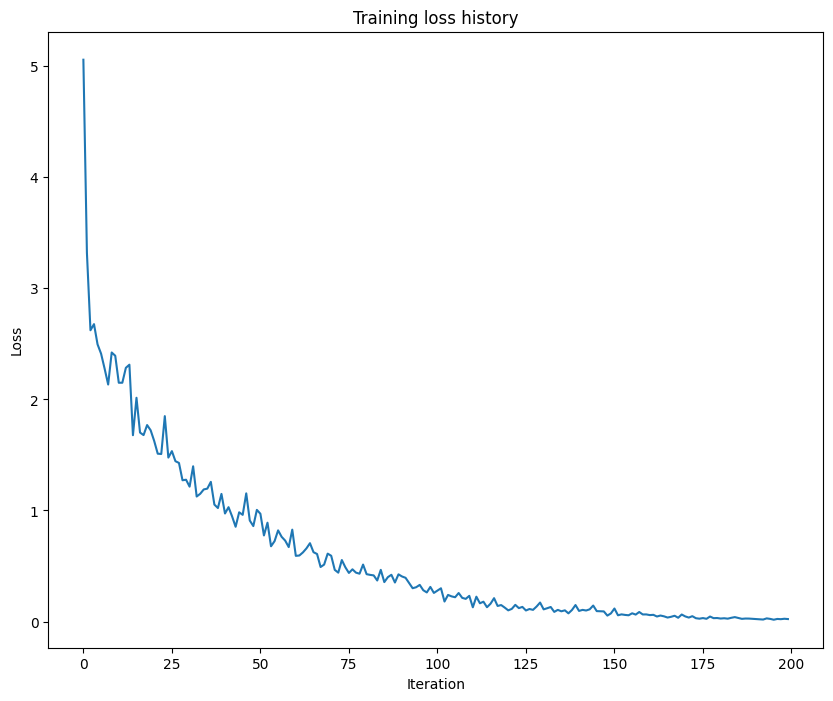

In [14]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

학습을 완료한 뒤 final loss 값을 프린트 합니다.
**본 코드에서 측정하는 에러는 `0.03`보다 작아야 합니다.**

In [15]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.022478132


# Transformer Sampling at Test Time

아래 작성된 sampling 코드를 실행하여 학습이 완료된 transformer 모델로 이미지 캡셔닝을 수행해 봅니다.
학습 데이터에 대해서는 좋은 결과를 보이지만, 작은 데이터셋에 대해서 학습이 되었기 때문에 validation 데이터에 대해서는 성능이 좋지 못함을 확인 할 수 있습니다.

URL Error:  Gone http://farm1.staticflickr.com/202/487987371_489a65d670_z.jpg


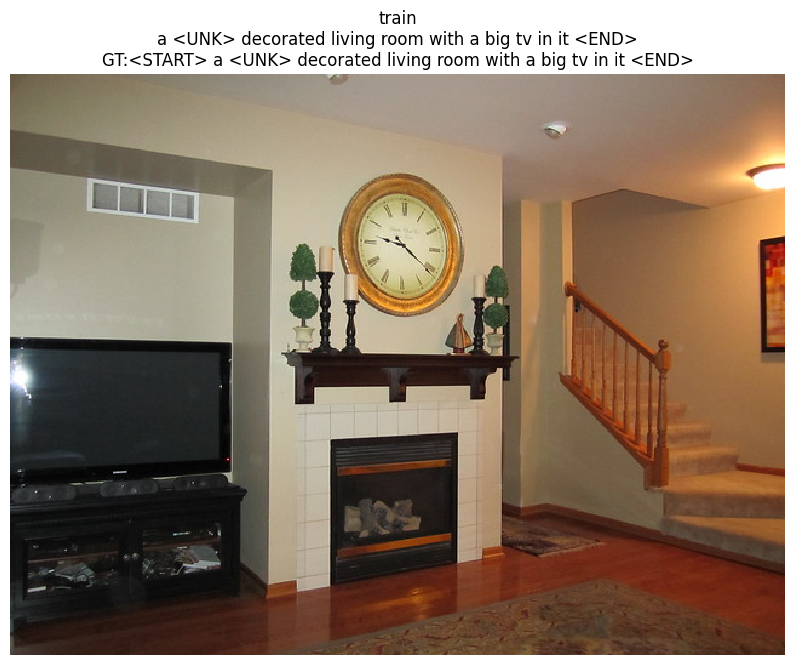

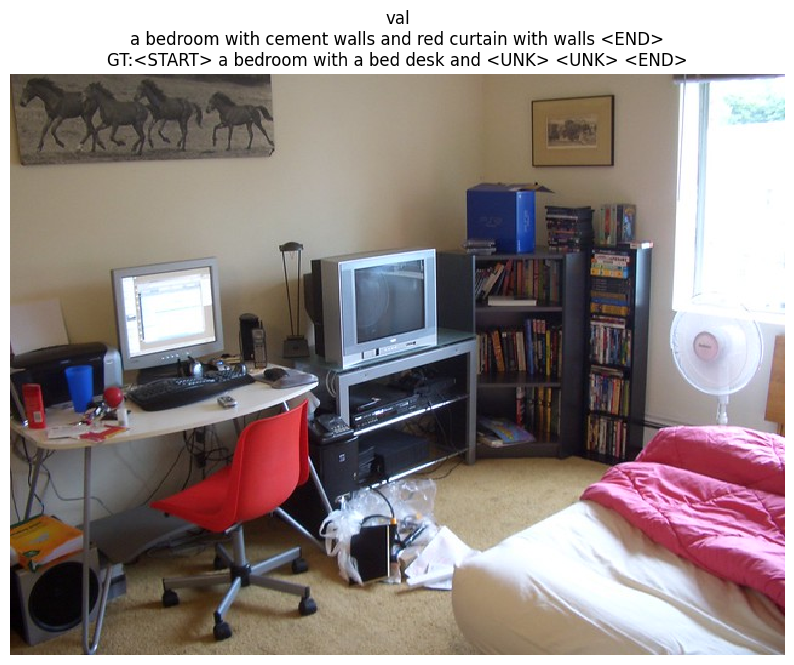

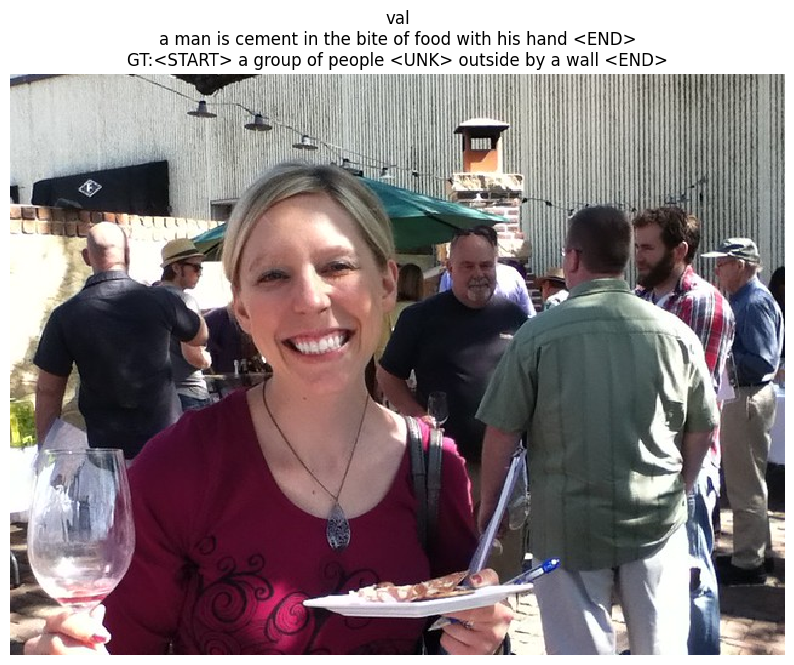

In [16]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()